# 강화학습 과제 1: SARSA, Q-Learning, Exploration 실험

## 1. 환경 설정 및 패키지 설치

In [16]:
# 필요한 패키지 설치 (처음 한 번만 실행)
!pip install numpy==1.21.6
!pip install pandas==1.3.5
!pip install setuptools wheel
!pip install gym==0.22
!pip install matplotlib==3.5.3
!pip install gym-minigrid==1.0.3
!pip install seaborn

ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement numpy==1.21.6 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 1.13.3, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.18.5, 1.19.0, 1.19.1, 1.19.2, 1.19.3, 1.19.4, 1.19.5, 1.20.0, 1.20.1, 1.20.2, 1.20.3, 1.21.0, 1.21.1, 1.22.0, 1.22.1, 1.22.2, 1.22.3, 1.22.4, 1.23.0, 1.23.1, 1.23.2, 1.23.3, 1.23

  Using cached pandas-1.3.5.tar.gz (4.7 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build pandas


  error: subprocess-exited-with-error
  
  × Building wheel for pandas (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [2481 lines of output]
      <string>:19: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
      C:\Users\osw01\AppData\Local\Temp\pip-build-env-5shor8ey\overlay\Lib\site-packages\setuptools\dist.py:759: SetuptoolsDeprecationWarning: License classifiers are deprecated.
      !!
      
              ********************************************************************************
              Please consider removing the following classifiers in favor of a SPDX license expression:
      
              License :: OSI Approved :: BSD License
      
              See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
              ********************************************************************************
      
      !!
        self._finaliz


[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached matplotlib-3.5.3.tar.gz (35.2 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for matplotlib
Failed to build matplotlib


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [595 lines of output]
      C:\Users\osw01\AppData\Local\Temp\pip-install-wq9815kf\matplotlib_e8f73c6aa3f04c358f4432cbb8aa14e4\setup.py:70: SetuptoolsDeprecationWarning: The test command is disabled and references to it are deprecated.
      !!
      
              ********************************************************************************
              Please remove any references to `setuptools.command.test` in all supported versions of the affected package.
      
              This deprecation is overdue, please update your project and remove deprecated
              calls to avoid build errors in the future.
              ********************************************************************************
      
      !!
        class NoopTestCommand(setuptools.command.test.test):
      
      Edit mplsetup.cfg to change the build options; suppress output with


[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict
import gym
import gym_minigrid
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

## 2. Utils 함수 정의

In [3]:
import base64
import glob
import io
from IPython.display import HTML
from IPython import display 
from gym import spaces
from gym_minigrid.minigrid import OBJECT_TO_IDX, COLOR_TO_IDX

max_env_steps = 50

class FlatObsWrapper(gym.core.ObservationWrapper):
    """Fully observable gridworld returning a flat grid encoding."""

    def __init__(self, env):
        super().__init__(env)
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),
            dtype='uint8'
        )
        self.unwrapped.max_steps = max_env_steps

    def observation(self, obs):
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])
        full_grid = full_grid[1:-1, 1:-1]
        
        flattened_grid = full_grid.ravel()
        return flattened_grid

def gen_wrapped_env(env_name):
    return FlatObsWrapper(gym.make(env_name))

## 3. Q-Learning과 SARSA 알고리즘 구현

In [4]:
class QLearning:
    def __init__(self, actions, agent_indicator=10):
        self.actions = actions
        self.agent_indicator = agent_indicator
        self.alpha = 0.01
        self.gamma = 0.9
        self.epsilon = 0.2
        self.q_values = defaultdict(lambda: [0.0] * actions)
        
    def _convert_state(self, s):
        return np.where(s == self.agent_indicator)[0][0]
        
    def update(self, state, action, reward, next_state, next_action):
        state = self._convert_state(state)
        next_state = self._convert_state(next_state)
        
        q_value = self.q_values[state][action]
        
        # Q-learning update rule
        next_q_value = max(self.q_values[next_state])
        td_error = reward + self.gamma * next_q_value - q_value
        self.q_values[state][action] = q_value + self.alpha * td_error
        
    def act(self, state):
        # Epsilon-greedy policy
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.actions)
        else:
            state = self._convert_state(state)
            q_values = self.q_values[state]
            action = np.argmax(q_values)
        return action

In [5]:
class SARSA:
    def __init__(self, actions, agent_indicator=10):
        self.actions = actions
        self.agent_indicator = agent_indicator
        self.alpha = 0.01
        self.gamma = 0.9
        self.epsilon = 0.2
        self.q_values = defaultdict(lambda: [0.0] * actions)
        
    def _convert_state(self, s):
        return np.where(s == self.agent_indicator)[0][0]
        
    def update(self, state, action, reward, next_state, next_action):
        state = self._convert_state(state)
        next_state = self._convert_state(next_state)
        
        q_value = self.q_values[state][action]
        
        # SARSA update rule
        next_q_value = self.q_values[next_state][next_action]
        td_error = reward + self.gamma * next_q_value - q_value
        self.q_values[state][action] = q_value + self.alpha * td_error
        
    def act(self, state):
        # Epsilon-greedy policy
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.actions)
        else:
            state = self._convert_state(state)
            q_values = self.q_values[state]
            action = np.argmax(q_values)
        return action

## 4. 과제 1: Q-Learning vs SARSA 비교 실험

In [8]:
def run_comparison_experiment():
    # 환경 설정
    env = gen_wrapped_env('MiniGrid-Empty-6x6-v0')
    obs = env.reset()
    agent_position = obs[0]
    
    # 에이전트 생성
    q_learning_agent = QLearning(4, agent_position)
    sarsa_agent = SARSA(4, agent_position)
    
    # 학습 데이터 저장용 리스트
    q_rewards = []
    sarsa_rewards = []
    q_success = []
    sarsa_success = []
    
    episodes = 5000
    
    # Q-Learning 학습
    print("Training Q-Learning...")
    for ep in range(episodes):
        done = False
        obs = env.reset()
        action = q_learning_agent.act(obs)
        
        ep_rewards = 0
        while not done:
            next_obs, reward, done, info = env.step(action)
            next_action = q_learning_agent.act(next_obs)
            
            q_learning_agent.update(obs, action, reward, next_obs, next_action)
            
            ep_rewards += reward
            obs = next_obs
            action = next_action
        
        q_rewards.append(ep_rewards)
        q_success.append(1 if ep_rewards > 0 else 0)
        
        if (ep+1) % 500 == 0:
            print(f"Episode: {ep+1}, Average Reward: {np.mean(q_rewards[-100:]):.3f}")
    
    # SARSA 학습
    print("\nTraining SARSA...")
    env = gen_wrapped_env('MiniGrid-Empty-6x6-v0')
    
    for ep in range(episodes):
        done = False
        obs = env.reset()
        action = sarsa_agent.act(obs)
        
        ep_rewards = 0
        while not done:
            next_obs, reward, done, info = env.step(action)
            next_action = sarsa_agent.act(next_obs)
            
            sarsa_agent.update(obs, action, reward, next_obs, next_action)
            
            ep_rewards += reward
            obs = next_obs
            action = next_action
        
        sarsa_rewards.append(ep_rewards)
        sarsa_success.append(1 if ep_rewards > 0 else 0)
        
        if (ep+1) % 500 == 0:
            print(f"Episode: {ep+1}, Average Reward: {np.mean(sarsa_rewards[-100:]):.3f}")
    
    # 결과 시각화
    plt.figure(figsize=(15, 5))
    
    # 누적 평균 보상
    plt.subplot(1, 3, 1)
    q_cumulative = np.cumsum(q_rewards) / (np.arange(len(q_rewards)) + 1)
    sarsa_cumulative = np.cumsum(sarsa_rewards) / (np.arange(len(sarsa_rewards)) + 1)
    plt.plot(q_cumulative, label='Q-Learning')
    plt.plot(sarsa_cumulative, label='SARSA')
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.title('Cumulative Average Reward')
    plt.legend()
    
    # 성공률
    plt.subplot(1, 3, 2)
    window = 100
    q_success_rate = pd.Series(q_success).rolling(window).mean()
    sarsa_success_rate = pd.Series(sarsa_success).rolling(window).mean()
    plt.plot(q_success_rate, label='Q-Learning')
    plt.plot(sarsa_success_rate, label='SARSA')
    plt.xlabel('Episodes')
    plt.ylabel('Success Rate')
    plt.title(f'Success Rate (Window: {window})')
    plt.legend()
    
    # Q-table 비교
    plt.subplot(1, 3, 3)
    # 공통 상태만 비교
    common_states = set(q_learning_agent.q_values.keys()) & set(sarsa_agent.q_values.keys())
    common_states = sorted(list(common_states))
    
    q_avg_values = [np.mean(q_learning_agent.q_values[state]) for state in common_states]
    sarsa_avg_values = [np.mean(sarsa_agent.q_values[state]) for state in common_states]
    
    x = range(len(common_states))
    plt.bar([i-0.2 for i in x], q_avg_values, width=0.4, label='Q-Learning', alpha=0.7)
    plt.bar([i+0.2 for i in x], sarsa_avg_values, width=0.4, label='SARSA', alpha=0.7)
    plt.xlabel('States')
    plt.ylabel('Average Q-values')
    plt.title('Average Q-values per State')
    plt.legend()
    plt.xticks(x, [f'S{state}' for state in common_states], rotation=45)
    
    plt.tight_layout()
    plt.savefig('task1_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 최종 성능 출력
    print("\n=== Final Performance ===")
    print(f"Q-Learning - Average Reward: {np.mean(q_rewards[-100:]):.3f}")
    print(f"Q-Learning - Success Rate: {np.mean(q_success[-100:]):.3f}")
    print(f"SARSA - Average Reward: {np.mean(sarsa_rewards[-100:]):.3f}")
    print(f"SARSA - Success Rate: {np.mean(sarsa_success[-100:]):.3f}")

Training Q-Learning...
Episode: 500, Average Reward: 0.000
Episode: 1000, Average Reward: 0.000
Episode: 1500, Average Reward: 0.000
Episode: 2000, Average Reward: 0.000
Episode: 2500, Average Reward: 0.002
Episode: 3000, Average Reward: 0.301
Episode: 3500, Average Reward: 0.280
Episode: 4000, Average Reward: 0.296
Episode: 4500, Average Reward: 0.298
Episode: 5000, Average Reward: 0.281

Training SARSA...
Episode: 500, Average Reward: 0.000
Episode: 1000, Average Reward: 0.302
Episode: 1500, Average Reward: 0.270
Episode: 2000, Average Reward: 0.273
Episode: 2500, Average Reward: 0.267
Episode: 3000, Average Reward: 0.326
Episode: 3500, Average Reward: 0.307
Episode: 4000, Average Reward: 0.297
Episode: 4500, Average Reward: 0.223
Episode: 5000, Average Reward: 0.292


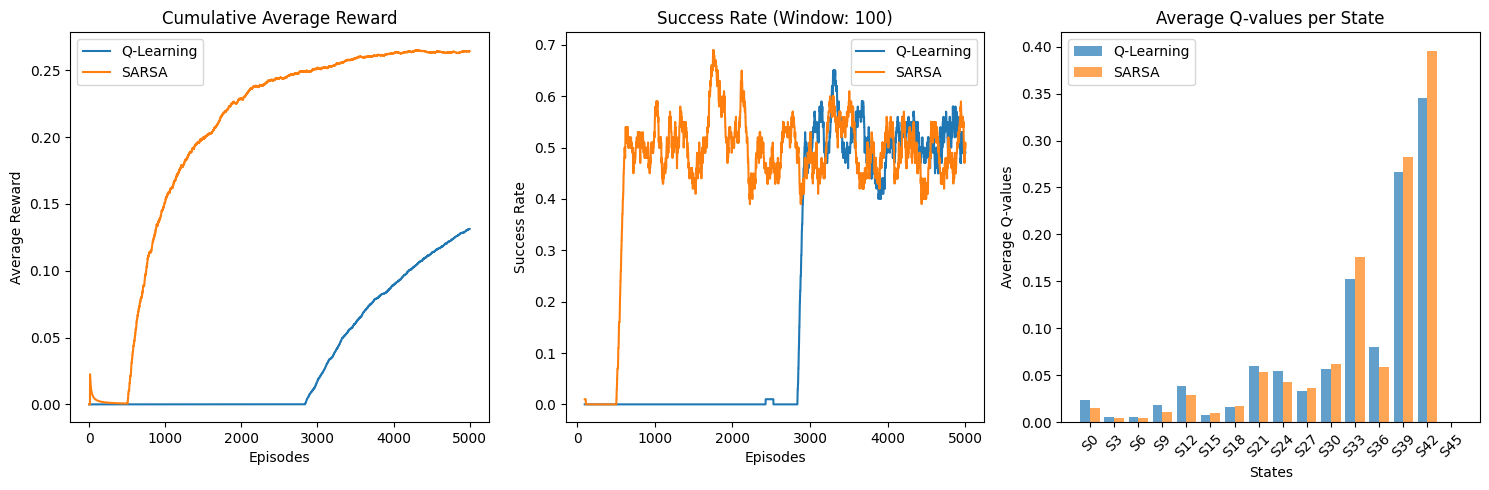


=== Final Performance ===
Q-Learning - Average Reward: 0.281
Q-Learning - Success Rate: 0.490
SARSA - Average Reward: 0.292
SARSA - Success Rate: 0.500


In [9]:
# 과제 1 실험 실행
run_comparison_experiment()

## 5. 과제 3: Discount Factor (γ) 실험

In [ ]:
def run_gamma_experiment():
    env = gen_wrapped_env('MiniGrid-Empty-6x6-v0')  
    gamma_values = [0.1, 0.5, 0.9, 0.99]
    results = {}
    
    for gamma in gamma_values:
        print(f"\nTraining with gamma = {gamma}")
        
        # 에이전트 생성
        obs = env.reset()
        agent_position = obs[0]
        agent = QLearning(4, agent_position)
        agent.gamma = gamma  # gamma 값 설정
        
        rewards = []
        episodes = 20000
        
        for ep in range(episodes):
            done = False
            obs = env.reset()
            action = agent.act(obs)
            
            ep_rewards = 0
            while not done:
                next_obs, reward, done, info = env.step(action)
                next_action = agent.act(next_obs)
                
                agent.update(obs, action, reward, next_obs, next_action)
                
                ep_rewards += reward
                obs = next_obs
                action = next_action
            
            rewards.append(ep_rewards)
            
            if (ep+1) % 1000 == 0:
                print(f"Episode: {ep+1}, Average Reward: {np.mean(rewards[-100:]):.3f}")
        
        results[gamma] = (rewards, agent)
    
    # 결과 시각화
    plt.figure(figsize=(15, 10))
    
    # 누적 평균 보상
    plt.subplot(2, 2, 1)
    for gamma, (rewards, _) in results.items():
        cumulative = np.cumsum(rewards) / (np.arange(len(rewards)) + 1)
        plt.plot(cumulative, label=f'γ = {gamma}')
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.title('Cumulative Average Reward')
    plt.legend()
    
    # 이동 평균 보상
    plt.subplot(2, 2, 2)
    window = 100
    for gamma, (rewards, _) in results.items():
        moving_avg = pd.Series(rewards).rolling(window).mean()
        plt.plot(moving_avg, label=f'γ = {gamma}')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title(f'Moving Average Reward (Window: {window})')
    plt.legend()
    
    # 최종 보상 분포
    plt.subplot(2, 2, 3)
    final_rewards = []
    labels = []
    for gamma, (rewards, _) in results.items():
        final_rewards.append(rewards[-1000:])
        labels.append(f'γ = {gamma}')
    plt.boxplot(final_rewards, labels=labels)
    plt.ylabel('Episode Reward')
    plt.title('Last 1000 Episodes Reward Distribution')
    
    # Q-value 비교
    plt.subplot(2, 2, 4)
    bar_width = 0.2
    for i, (gamma, (_, agent)) in enumerate(results.items()):
        avg_q_values = [np.mean(q) for q in agent.q_values.values()]
        x_positions = [x + i * bar_width for x in range(len(avg_q_values))]
        plt.bar(x_positions, avg_q_values, width=bar_width, label=f'γ = {gamma}', alpha=0.7)
    plt.xlabel('States')
    plt.ylabel('Average Q-values')
    plt.title('Average Q-values by Gamma')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('task3_gamma_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 최종 성능 출력
    print("\n=== Performance by Gamma Value ===")
    for gamma, (rewards, _) in results.items():
        final_avg = np.mean(rewards[-1000:])
        success_rate = np.mean([1 if r > 0 else 0 for r in rewards[-1000:]])
        print(f"γ = {gamma:4.2f} | Average Reward: {final_avg:6.3f} | Success Rate: {success_rate:6.3f}")


Training with gamma = 0.1
Episode: 1000, Average Reward: 0.000
Episode: 2000, Average Reward: 0.322
Episode: 3000, Average Reward: 0.324
Episode: 4000, Average Reward: 0.292
Episode: 5000, Average Reward: 0.260
Episode: 6000, Average Reward: 0.298
Episode: 7000, Average Reward: 0.334
Episode: 8000, Average Reward: 0.282
Episode: 9000, Average Reward: 0.384
Episode: 10000, Average Reward: 0.318
Episode: 11000, Average Reward: 0.296
Episode: 12000, Average Reward: 0.276
Episode: 13000, Average Reward: 0.305
Episode: 14000, Average Reward: 0.276
Episode: 15000, Average Reward: 0.212
Episode: 16000, Average Reward: 0.313
Episode: 17000, Average Reward: 0.359
Episode: 18000, Average Reward: 0.340
Episode: 19000, Average Reward: 0.274
Episode: 20000, Average Reward: 0.302

Training with gamma = 0.5
Episode: 1000, Average Reward: 0.000
Episode: 2000, Average Reward: 0.000
Episode: 3000, Average Reward: 0.000
Episode: 4000, Average Reward: 0.000
Episode: 5000, Average Reward: 0.334
Episode: 6

C:\Users\osw01\AppData\Local\Temp\ipykernel_23008\2820599600.py:72: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(final_rewards, labels=labels)


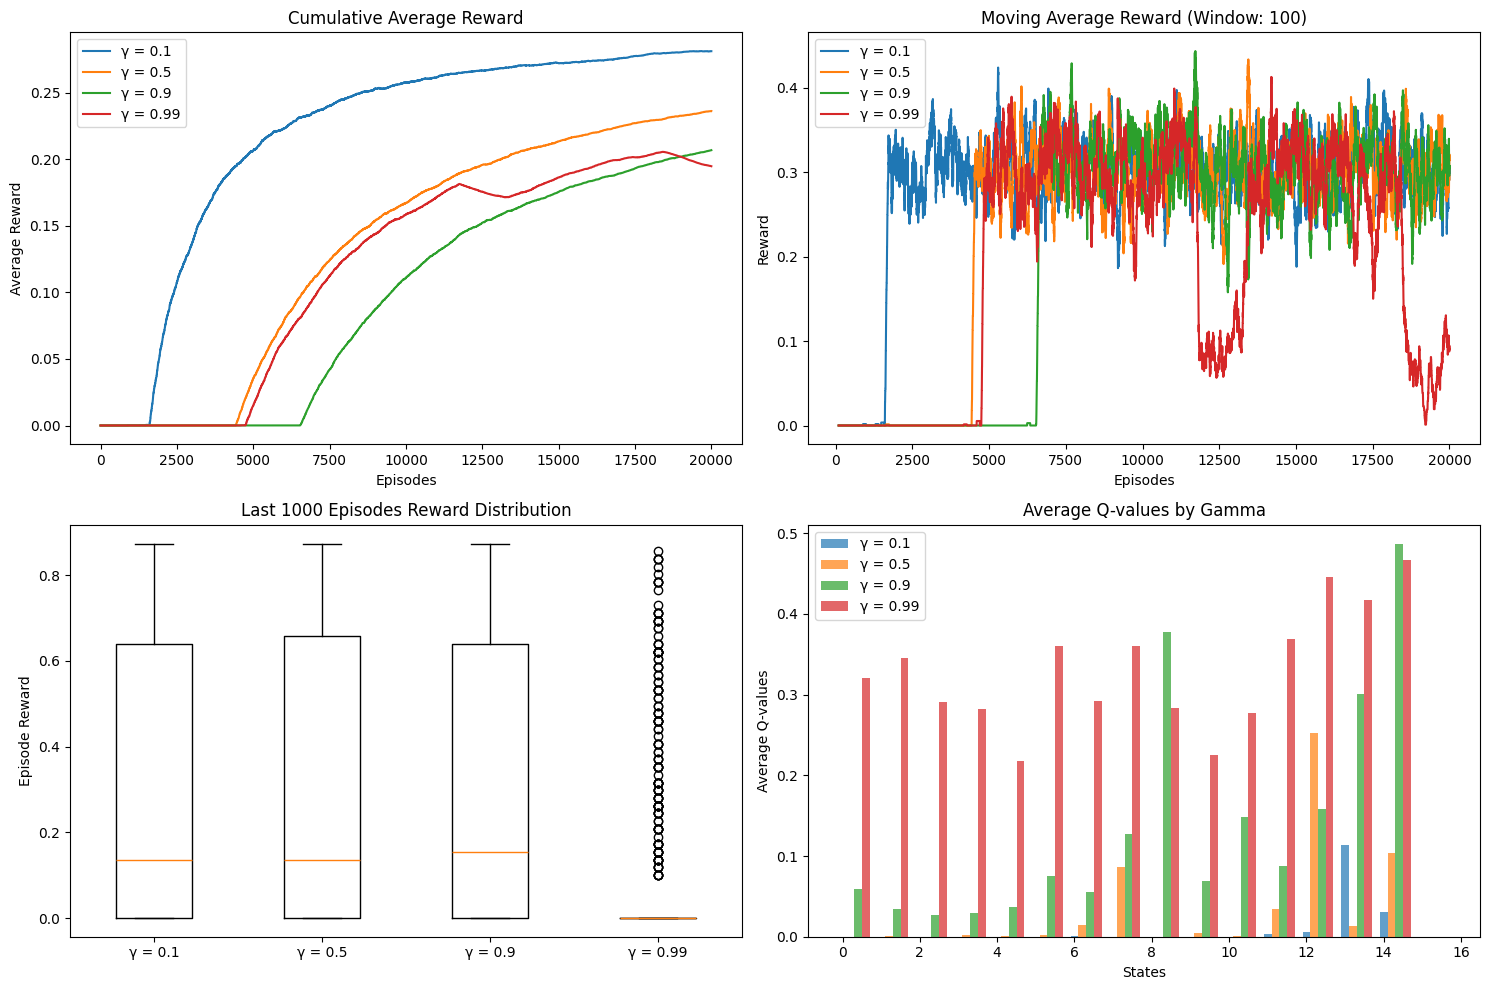


=== Performance by Gamma Value ===
γ = 0.10 | Average Reward:  0.299 | Success Rate:  0.515
γ = 0.50 | Average Reward:  0.306 | Success Rate:  0.521
γ = 0.90 | Average Reward:  0.300 | Success Rate:  0.522
γ = 0.99 | Average Reward:  0.061 | Success Rate:  0.148


In [13]:
# 과제 3 실험 실행
run_gamma_experiment()